In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 26, 11, 1, 39, 60395)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-26 11:01:39,140 INFO: Initializing external client


2025-01-26 11:01:39,140 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-26 11:01:40,772 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-29 21:00:00+00:00,2.90,-1.473485,0.0,0.0,14.480773,31637.470703,0.0,dublin,1,2,21
1,2025-01-29 19:00:00+00:00,3.95,-0.696140,0.0,0.0,17.399586,31637.470703,0.0,dublin,1,2,19
2,2025-01-27 09:00:00+00:00,6.50,1.110262,2.3,0.0,28.116899,31225.949219,8.4,dublin,1,0,9
3,2025-01-27 18:00:00+00:00,7.45,4.353729,0.0,0.0,14.003028,31225.949219,8.4,dublin,1,0,18
4,2025-01-28 23:00:00+00:00,2.65,-1.705188,0.0,0.0,16.935310,31429.511719,1.8,dublin,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025-02-04 06:00:00+00:00,9.80,5.514887,0.0,0.0,27.086262,32959.515625,2.8,dublin,2,1,6
223,2025-02-04 03:00:00+00:00,10.00,6.139652,0.0,0.0,24.535526,32959.515625,2.8,dublin,2,1,3
224,2025-02-04 10:00:00+00:00,10.80,5.914645,0.0,0.0,31.820820,32959.515625,2.8,dublin,2,1,10
225,2025-02-04 22:00:00+00:00,6.10,3.649094,0.2,0.0,8.759178,32959.515625,2.8,dublin,2,1,22


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-29 21:00:00+00:00,2.90,-1.473485,0.0,0.0,14.480773,31637.470703,0.0,dublin,1,2,21,37
1,2025-01-29 19:00:00+00:00,3.95,-0.696140,0.0,0.0,17.399586,31637.470703,0.0,dublin,1,2,19,39
2,2025-01-27 09:00:00+00:00,6.50,1.110262,2.3,0.0,28.116899,31225.949219,8.4,dublin,1,0,9,15
3,2025-01-27 18:00:00+00:00,7.45,4.353729,0.0,0.0,14.003028,31225.949219,8.4,dublin,1,0,18,29
4,2025-01-28 23:00:00+00:00,2.65,-1.705188,0.0,0.0,16.935310,31429.511719,1.8,dublin,1,1,23,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2025-02-04 06:00:00+00:00,9.80,5.514887,0.0,0.0,27.086262,32959.515625,2.8,dublin,2,1,6,33
223,2025-02-04 03:00:00+00:00,10.00,6.139652,0.0,0.0,24.535526,32959.515625,2.8,dublin,2,1,3,34
224,2025-02-04 10:00:00+00:00,10.80,5.914645,0.0,0.0,31.820820,32959.515625,2.8,dublin,2,1,10,9
225,2025-02-04 22:00:00+00:00,6.10,3.649094,0.2,0.0,8.759178,32959.515625,2.8,dublin,2,1,22,38


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
49,2025-01-26 13:00:00+00:00,6.45,-0.577816,0.9,0.0,40.199284,31026.716797,8.999999,dublin,1,6,13,38,1
26,2025-01-26 14:00:00+00:00,7.80,2.292023,0.9,0.0,31.322069,31026.716797,8.999999,dublin,1,6,14,38,2
9,2025-01-26 15:00:00+00:00,8.70,4.117027,0.9,0.0,25.872454,31026.716797,8.999999,dublin,1,6,15,37,3
47,2025-01-26 16:00:00+00:00,8.80,4.432523,0.0,0.0,24.014996,31026.716797,8.999999,dublin,1,6,16,35,4
25,2025-01-26 17:00:00+00:00,8.50,4.145185,0.0,0.0,22.668568,31026.716797,8.999999,dublin,1,6,17,37,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2025-02-04 19:00:00+00:00,6.90,4.036785,0.2,0.0,12.069400,32959.515625,2.800000,dublin,2,1,19,36,223
207,2025-02-04 20:00:00+00:00,6.65,3.882977,0.2,0.0,11.275530,32959.515625,2.800000,dublin,2,1,20,37,224
214,2025-02-04 21:00:00+00:00,6.40,3.793025,0.2,0.0,10.041354,32959.515625,2.800000,dublin,2,1,21,38,225
225,2025-02-04 22:00:00+00:00,6.10,3.649094,0.2,0.0,8.759178,32959.515625,2.800000,dublin,2,1,22,38,226


## Create forecast graph

2025-01-26 11:01:49,829 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



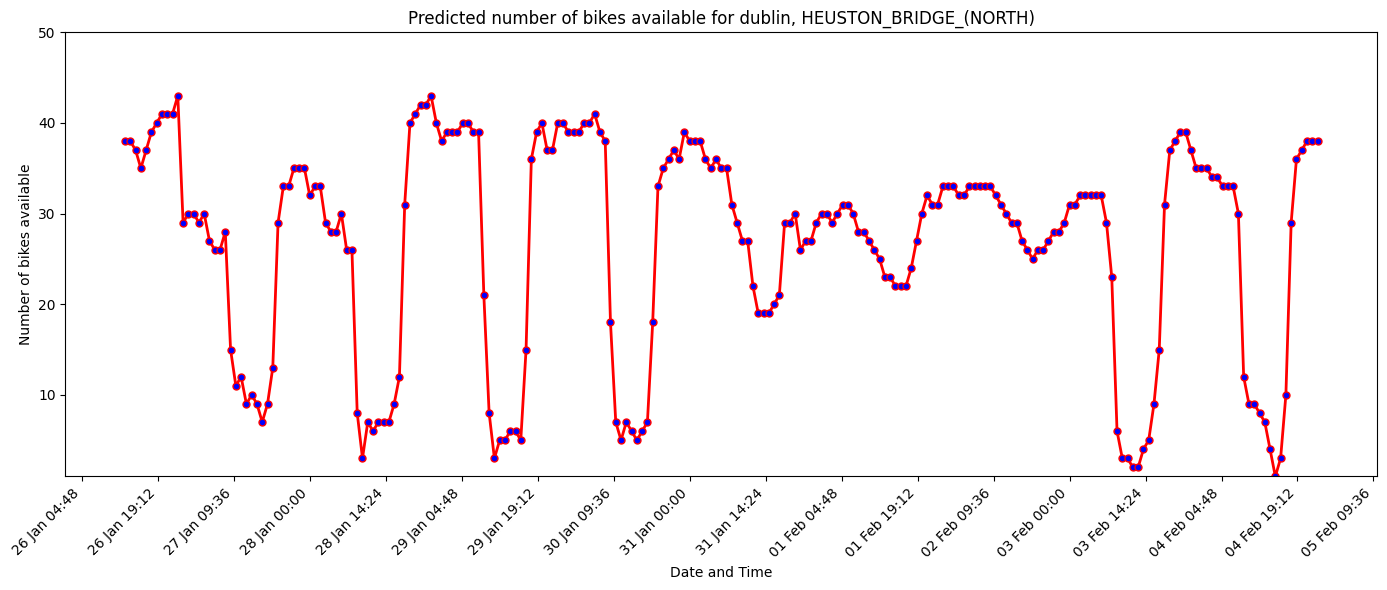

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |                                     | Rows 0/227 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 0.44% |▏                                | Rows 1/227 | Elapsed Time: 00:01 | Remaining Time: 04:20

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 227/227 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: bike_availability_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


2025-01-26 11:02:06,431 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-01-26 11:02:09,624 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-01-26 11:04:27,379 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-01-26 11:04:27,538 INFO: Waiting for log aggregation to finish.


2025-01-26 11:04:36,156 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-24 03:00:00+00:00,11.300000,5.056276,1.9,0.0,41.104683,30634.960938,7.5,dublin,1,4,3,41,18
1,2025-01-23 01:00:00+00:00,4.650000,1.574594,0.0,0.0,11.019764,30442.521484,2.9,dublin,1,3,1,39,15
2,2025-01-25 05:00:00+00:00,1.300000,-4.210609,0.0,0.0,20.326454,30829.769531,2.1,dublin,1,5,5,41,19
3,2025-01-27 04:00:00+00:00,5.600000,1.149379,0.1,0.0,17.418196,31225.949219,8.4,dublin,1,0,4,30,16
4,2025-01-24 10:00:00+00:00,5.550000,-3.144419,0.0,0.0,45.814861,30634.960938,6.0,dublin,1,4,10,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2024-12-28 06:00:00+00:00,8.689500,6.399599,0.0,0.0,11.931705,27194.826172,0.0,dublin,12,5,6,40,6
161,2024-12-28 08:00:00+00:00,8.639501,6.310997,0.0,0.0,12.456468,27194.826172,0.0,dublin,12,5,8,40,8
162,2024-12-29 00:00:00+00:00,7.939500,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,24
163,2024-12-28 17:00:00+00:00,8.789500,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,17


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9689,2025-01-25 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),38.0
9690,2025-01-25 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9691,2025-01-25 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),38.0
9692,2025-01-25 21:00:00+00:00,HEUSTON_BRIDGE_(NORTH),39.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12811,2025-02-04 06:00:00+00:00,9.8000,5.514887,0.0,0.0,27.086262,32959.515625,2.8,dublin
12812,2025-02-04 03:00:00+00:00,10.0000,6.139652,0.0,0.0,24.535526,32959.515625,2.8,dublin
12813,2025-02-04 10:00:00+00:00,10.8000,5.914645,0.0,0.0,31.820820,32959.515625,2.8,dublin
12814,2025-02-04 22:00:00+00:00,6.1000,3.649094,0.2,0.0,8.759178,32959.515625,2.8,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

132


,datetime,predicted_bikes_available,num_bikes_available
131,2024-12-28 01:00:00+00:00,39,39.0
114,2024-12-28 02:00:00+00:00,40,39.0
124,2024-12-28 03:00:00+00:00,40,39.0
108,2024-12-28 04:00:00+00:00,39,39.0
116,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
35,2025-01-25 20:00:00+00:00,37,40.0
16,2025-01-25 21:00:00+00:00,36,39.0
84,2025-01-25 22:00:00+00:00,36,38.0
83,2025-01-25 23:00:00+00:00,36,38.0


In [20]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9673,2025-01-25 20:00:00+00:00,40.0
9692,2025-01-25 21:00:00+00:00,39.0
9689,2025-01-25 22:00:00+00:00,38.0
9686,2025-01-25 23:00:00+00:00,38.0


In [21]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
164,2024-12-28 01:00:00+00:00,39
147,2024-12-28 02:00:00+00:00,40
157,2024-12-28 03:00:00+00:00,40
141,2024-12-28 04:00:00+00:00,39
149,2024-12-28 05:00:00+00:00,38
...,...,...
45,2025-01-27 08:00:00+00:00,28
7,2025-01-27 09:00:00+00:00,15
138,2025-01-27 10:00:00+00:00,11
103,2025-01-27 11:00:00+00:00,12


In [22]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  132


,datetime,predicted_bikes_available,num_bikes_available
131,2024-12-28 01:00:00+00:00,39,39.0
114,2024-12-28 02:00:00+00:00,40,39.0
124,2024-12-28 03:00:00+00:00,40,39.0
108,2024-12-28 04:00:00+00:00,39,39.0
116,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
35,2025-01-25 20:00:00+00:00,37,40.0
16,2025-01-25 21:00:00+00:00,36,39.0
84,2025-01-25 22:00:00+00:00,36,38.0
83,2025-01-25 23:00:00+00:00,36,38.0


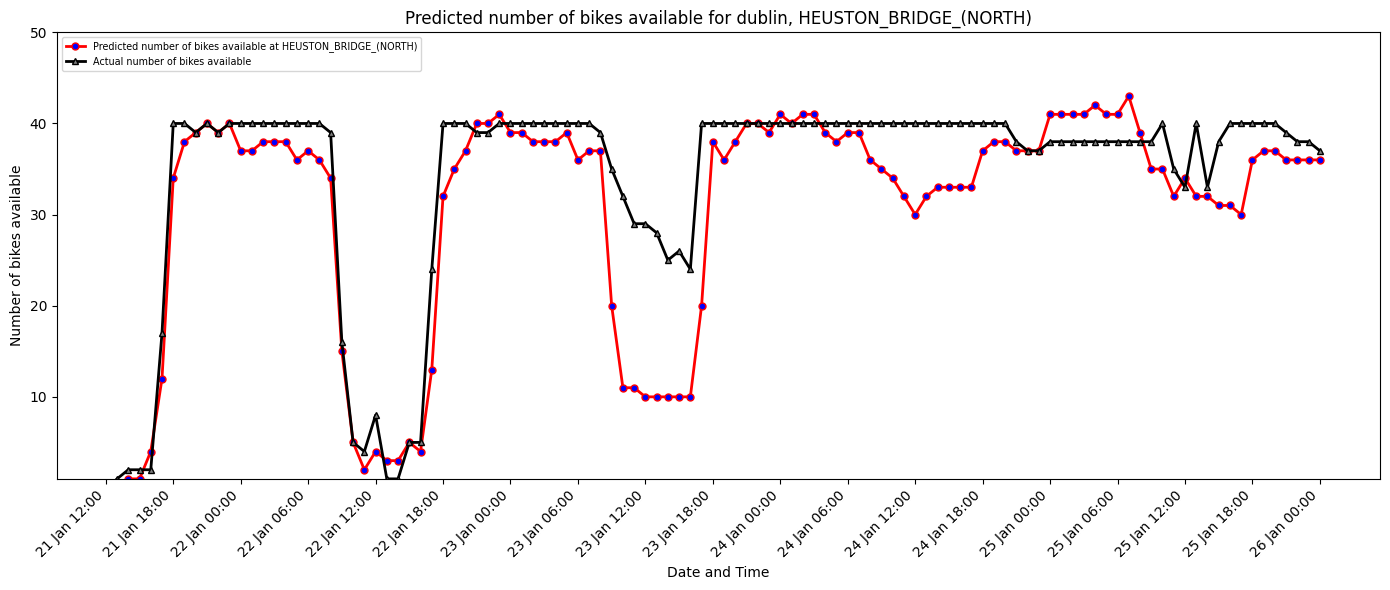

In [23]:
file_path = "docs/bike_availability_hindcast_10days.png"
import pytz

today = datetime.datetime.now(pytz.utc)
hindcast_df_10days = hindcast_df[hindcast_df['datetime'] >= today - datetime.timedelta(days=10)]

plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df_10days, file_path, hindcast=True)
plt.show()